In [1]:
#Import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import graphviz
import sklearn.tree
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from numpy import nan
from numpy import round
from IPython.display import Image
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold 
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import StratifiedKFold, KFold
from io import StringIO
%matplotlib inline

/Users/anveshd9/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Lending Club is a US peer-to-peer lending company, headquartered in San Francisco, California. LC enables borrowers to create loan listings on its website by supplying details about themselves and the loans that they would like to request.

## Business Problem
Main aim of this project is to predict the borrowers who are more probable to default requested loan based on features extracted from their loan applicaiton request. For this project, we will consider data of loan borrowers from 2012 to 2013. This data is downloaded from their official website. 

As for any standard Machine Learning projecy, this notebook will follow standard steps of preparing the data, short-listing models, fine-tuning them and presenting final model with key findings

In [61]:
#import lendingclub dataset
lclub = pd.read_csv("/Users/anveshd9/Documents/Fall17/ML/Projects/Ind project/LendingClub2012to2013 (1).csv",
                    header = 1,low_memory=False)
lclub.shape

(188183, 115)

In [62]:
lclub.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10129506,11981122.0,20800.0,20800.0,20800.0,36 months,13.53%,706.16,B,B5,...,0.0,3.0,90.2,50.0,0.0,0.0,43100.0,23473.0,15000.0,0.0
1,10159498,1319523.0,12000.0,12000.0,12000.0,36 months,6.62%,368.45,A,A2,...,0.0,2.0,95.5,0.0,0.0,0.0,333044.0,42603.0,52600.0,42769.0
2,10129454,11981072.0,12000.0,12000.0,12000.0,36 months,10.99%,392.81,B,B2,...,0.0,4.0,100.0,0.0,0.0,0.0,29700.0,7137.0,18100.0,0.0
3,10139658,11991209.0,12000.0,12000.0,12000.0,36 months,13.53%,407.40,B,B5,...,0.0,2.0,81.2,33.3,0.0,0.0,18130.0,13605.0,7000.0,10030.0
4,10127816,11979581.0,24000.0,24000.0,24000.0,36 months,13.53%,814.80,B,B5,...,0.0,2.0,100.0,75.0,0.0,0.0,229072.0,61397.0,21500.0,58847.0


A total of 115 featues are present in the given data. Lets look at our dependent variable Loan_status

Loan_status variable explains if the loan has been paid completely, charged off or currrent. Our problem is to predict if a borrower pays his loan without defaulting/charged off from predictor features which includes demogrphic and other informatiom. Here we ignore data loan_status under 'Current','Late (31-120 days)','In Grace Period','Late (16-30 days)' categories as these are ongoing loans. We consider only closed cases for this project

We combine 'Charged off' and 'Default' and code it as 0, Similarly 'Fully Paid' as 1

In [63]:
#checking stats for  dependent variable 
lclub['loan_status'].value_counts()

Fully Paid            143919
Charged Off            27536
Current                15430
Late (31-120 days)       706
In Grace Period          387
Late (16-30 days)        175
Default                   28
Name: loan_status, dtype: int64

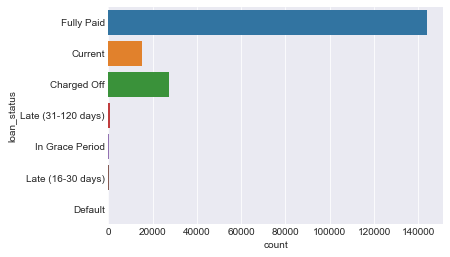

In [64]:
#frequency plot for dependent variable
sns.countplot(y="loan_status", data=lclub)

In [65]:
#Dropping entries with loan_status = ['Current' , Late(31-120), In Grace Period, Late(16-30)]
remove = lclub['loan_status'].isin(['Current','Late (31-120 days)','In Grace Period' ,'Late (16-30 days)'])
lclub = lclub[~remove]
lclub.shape

(171485, 115)

In [66]:
# Encoding target variable 
lclub['loan_status'] = lclub['loan_status'].replace(['Fully Paid' , 'Charged Off' , 'Default'] , ['1' , '0' , '0'])

In [67]:
#check value counts of each class
lclub['loan_status'].value_counts()

1    143919
0     27564
Name: loan_status, dtype: int64

In [10]:
#Check extent of missing values in the data
lclub.isnull().sum()/len(lclub)*100

id                                 0.000000
member_id                          0.001166
loan_amnt                          0.001166
funded_amnt                        0.001166
funded_amnt_inv                    0.001166
term                               0.001166
int_rate                           0.001166
installment                        0.001166
grade                              0.001166
sub_grade                          0.001166
emp_title                          6.318920
emp_length                         4.247602
home_ownership                     0.001166
annual_inc                         0.001166
verification_status                0.001166
issue_d                            0.001166
loan_status                        0.001166
pymnt_plan                         0.001166
url                                0.001166
desc                              56.113946
purpose                            0.001166
title                              0.004082
zip_code                        

In [69]:
#deleting columns with >50% missing values
null_pct = lclub.isnull().sum() / len(lclub)
missing_features = null_pct[null_pct > 0.50].index
lclub.drop(missing_features, axis=1, inplace=True)

In [70]:
lclub.shape

(171485, 91)

As many as 24 columns are dropped with >50% missing values

In [71]:
lc_cat = lclub.select_dtypes(include = ['object'])

In [72]:
#check unique entries for each categorical variable 
lccat_unique = []
for col in lc_cat.iloc[:,1:25]:
    lccat_unique.append([col, len(lc_cat[col].unique())])
print(lccat_unique)


[['term', 3], ['int_rate', 146], ['grade', 8], ['sub_grade', 36], ['emp_title', 106595], ['emp_length', 12], ['home_ownership', 6], ['verification_status', 4], ['issue_d', 25], ['loan_status', 3], ['pymnt_plan', 2], ['url', 171484], ['purpose', 14], ['title', 41909], ['zip_code', 840], ['addr_state', 50], ['earliest_cr_line', 611], ['revol_util', 1065], ['initial_list_status', 3], ['last_pymnt_d', 60], ['last_credit_pull_d', 61], ['application_type', 2]]


## Data Preprocessing

From the above distribution of unique length of each categorical variables, we can ignore 'emp_title' , 'url' , 'desc','title', 'id'   and continue to investigate remaining variables. 'desc' , 'title' are similar to 'purpose'Along with that we can exclude 'zip_code' and 'application_type'(only one category in applciation_type)

As we are trying to predict if the borrower can repay his loan based on his/her details provided, we need to ignore features which can only be known after loan is approved. Based on the metadata, below list features can be ignored
['recoveries', 'collection_recovery_fee', 'last_fico_range_high', 'last_fico_range_low', 'last_credit_pull_d', 'total_rec_prncp', 'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_d', 'total_rec_late_fee', 'total_rec_int', 'num_tl_30dpd', 'out_prncp', 'out_prncp_inv', 'pymnt_plan', 'next_pymnt_d' , 'funded_amnt' ,'num_tl_120dpd_2m','int_rate' , 'grade' , 'sub_grade']


In [75]:
#dropping text variables 
lclub = lclub.drop(['url','title','zip_code','emp_title', 'id', 'member_id','application_type'] , axis = 1)

#dropping irrelevant variables 

lclub = lclub.drop(['recoveries', 'collection_recovery_fee', 'last_fico_range_high',
                    'last_fico_range_low', 'last_credit_pull_d', 'total_rec_prncp', 
                    'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_d',
                    'total_rec_late_fee', 'total_rec_int', 'num_tl_30dpd', 'out_prncp', 'int_rate','grade', 'sub_grade',
                    'out_prncp_inv', 'pymnt_plan','funded_amnt' ,'num_tl_120dpd_2m'] , axis =1)


In [76]:
lclub.shape

(171485, 63)

In [77]:
#Changing categorical to numerical 'revol_until' variable
lclub['revol_util'] = lclub['revol_util'].str.replace('%','').astype(float)

In [78]:
#Divinding into categorical and continuous variables
lc_num = lclub.select_dtypes(exclude = ['object'])
lc_cat = lclub.select_dtypes(include = ['object'])

In [79]:
#define function for plotting  categorical vairbles
cat_list = list(lc_cat)
def cat_plot(df,cat_list):
    for x in cat_list:
        if df[x].nunique() <= 30:
            sns.countplot(y = df[x] , hue = df['loan_status'])
            plt.savefig('plot\\' + x)
            plt.show()
            plt.clf()

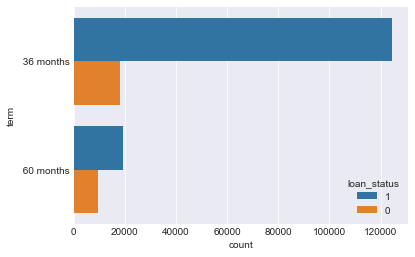

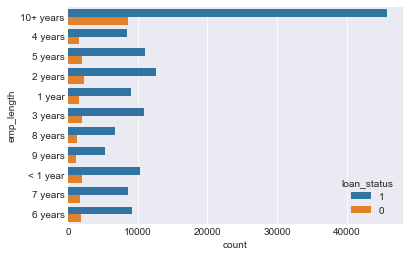

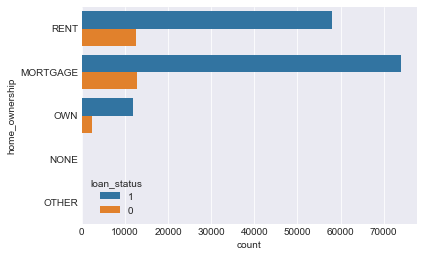

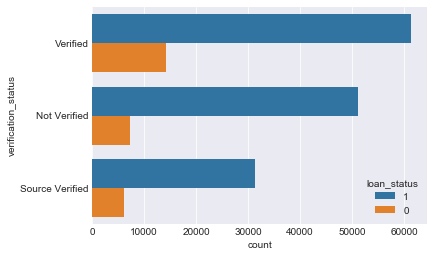

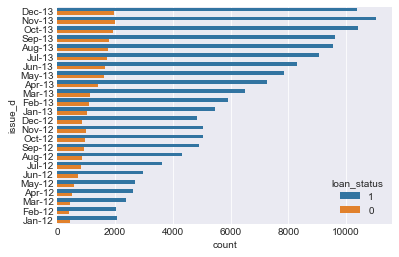

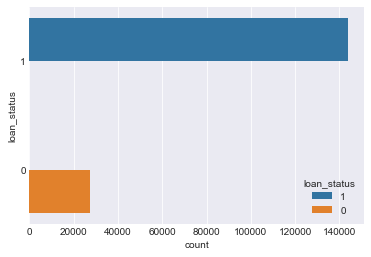

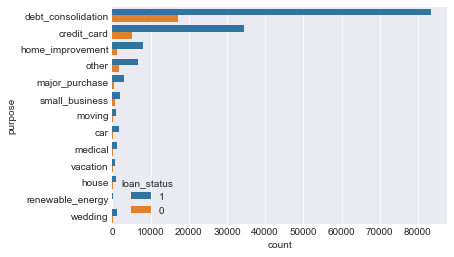

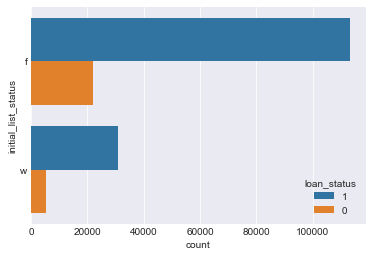

In [80]:
#Visualising categorical variiables 
import matplotlib.pyplot as plt
cat_plot(lc_cat,cat_list)

In [81]:
# Defining function to plot continuous variables 
import matplotlib.pyplot as plt
con_list = list(lc_num)
def con_plot(df,con_list):
    for x in con_list:
        sns.set_style("darkgrid")
        ax = sns.distplot(df[x].dropna(), hist = True, )
        ax.set(xlabel= x,  ylabel='% Distribution',title='Density Plot of ' + x)
        plt.savefig('continuous_univariate\\' + x)
        plt.show()
        plt.clf()

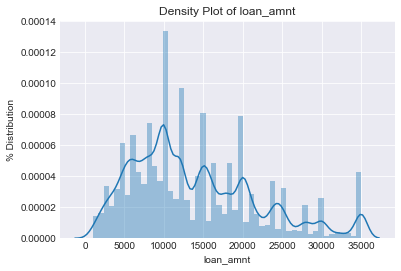

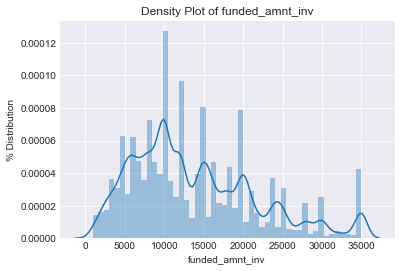

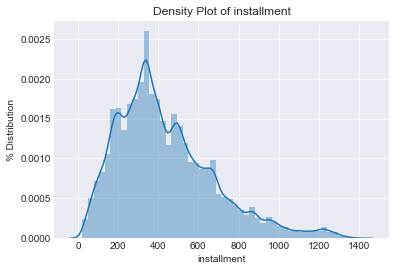

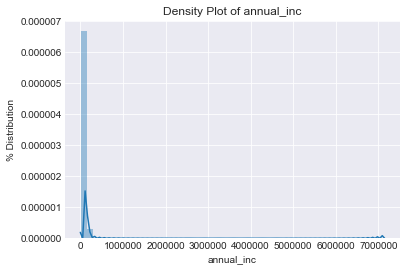

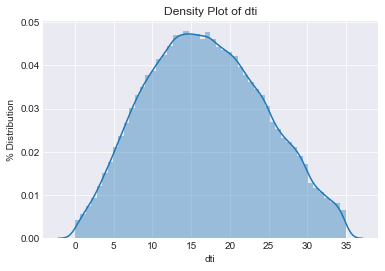

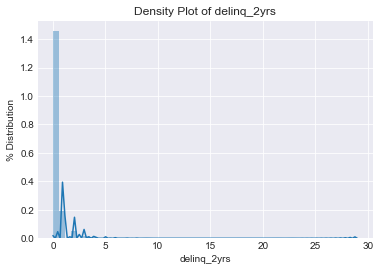

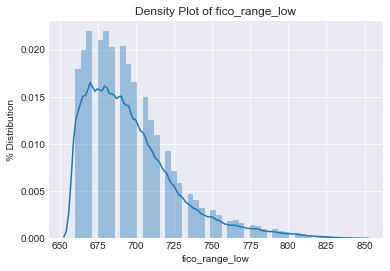

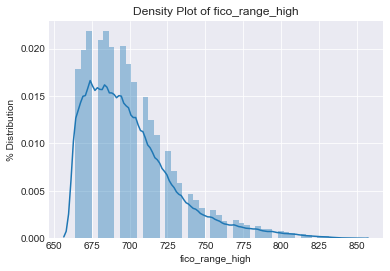

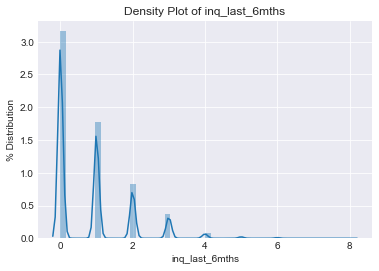

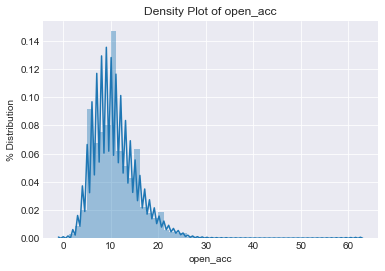

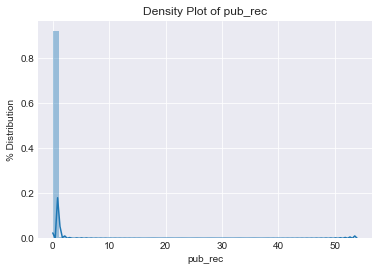

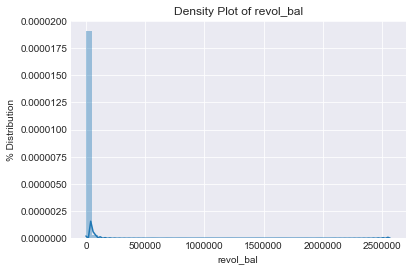

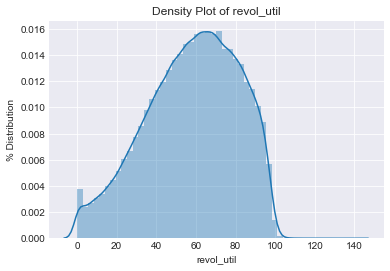

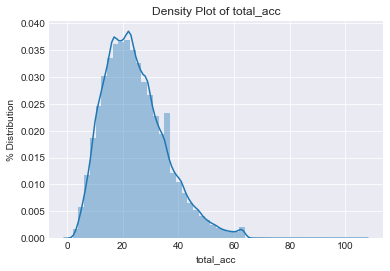

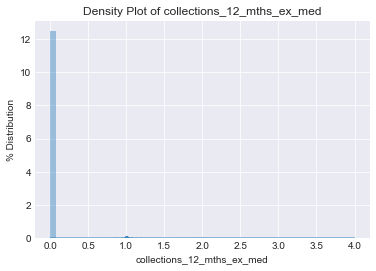

/Users/anveshd9/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/anveshd9/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/anveshd9/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


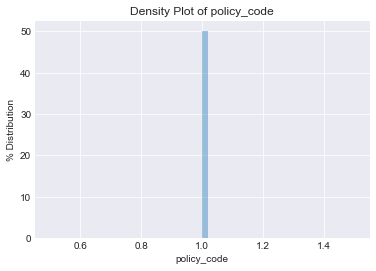

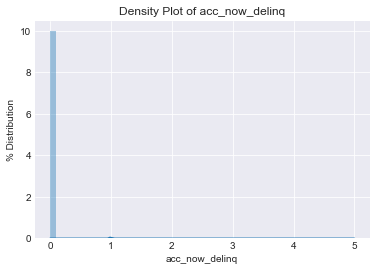

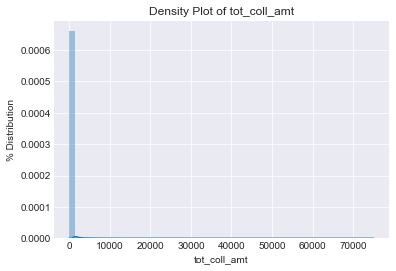

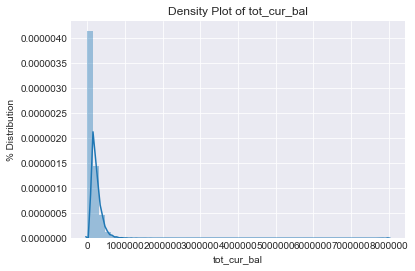

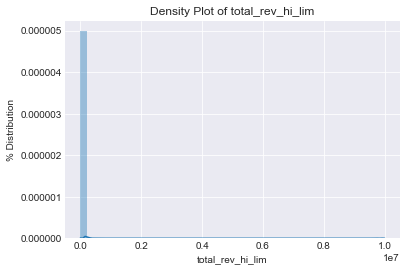

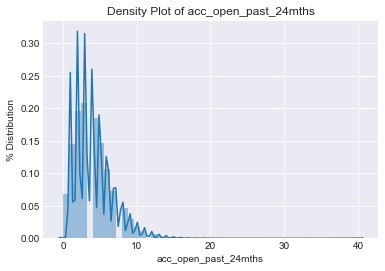

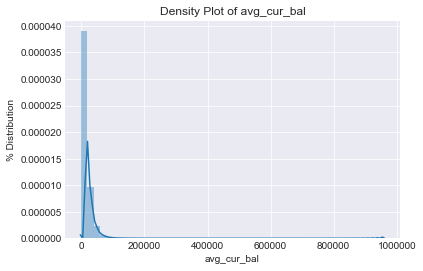

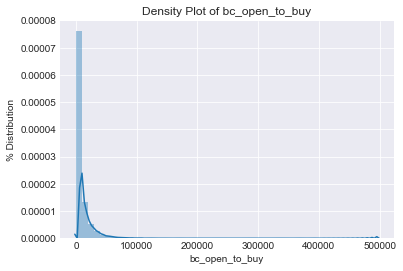

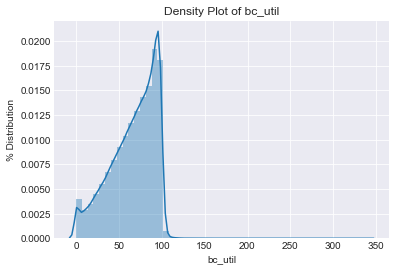

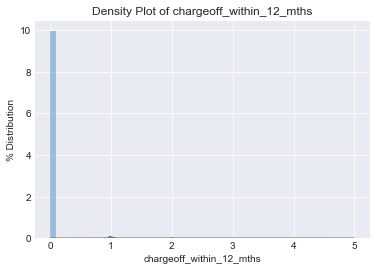

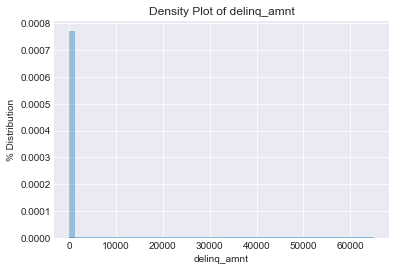

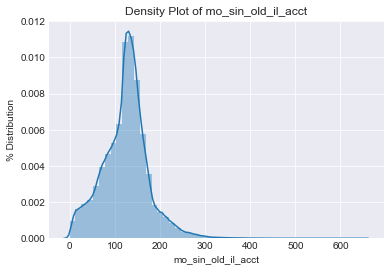

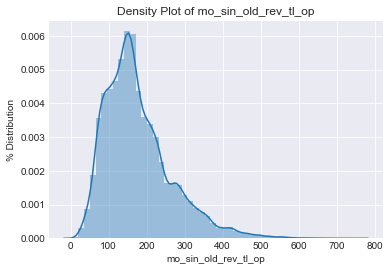

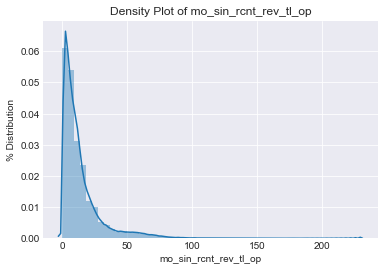

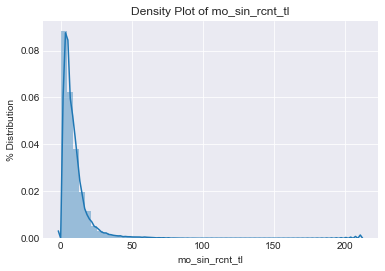

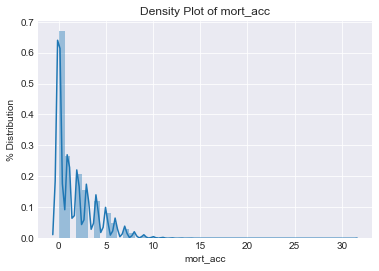

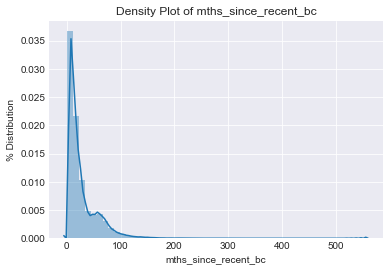

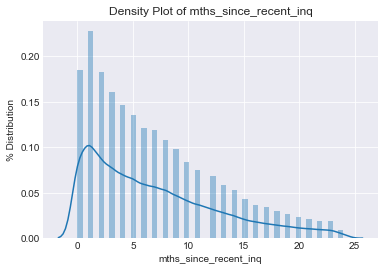

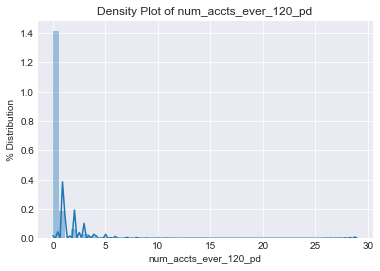

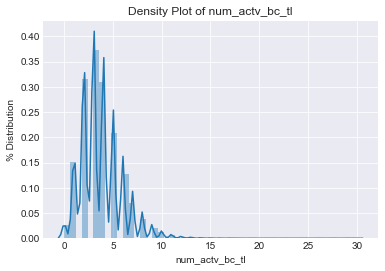

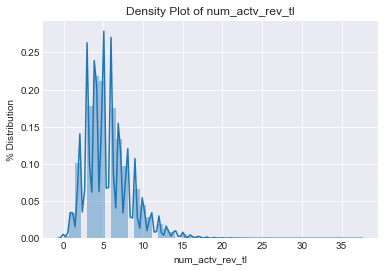

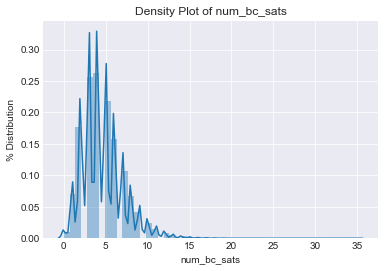

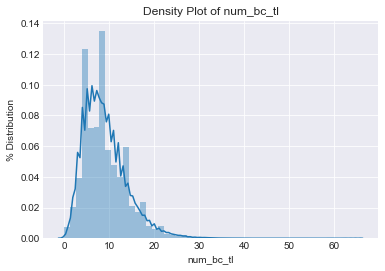

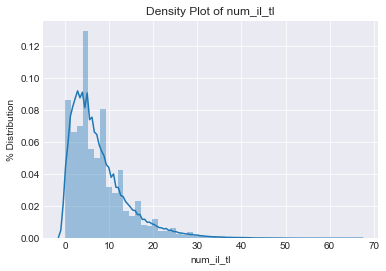

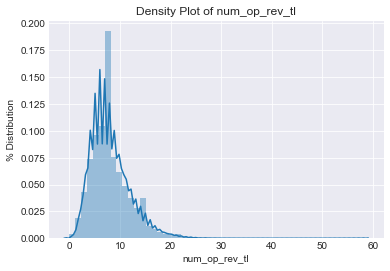

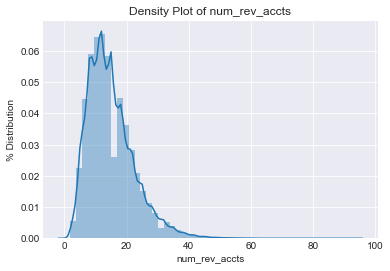

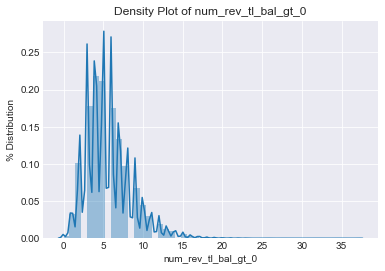

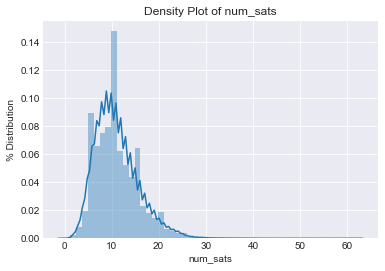

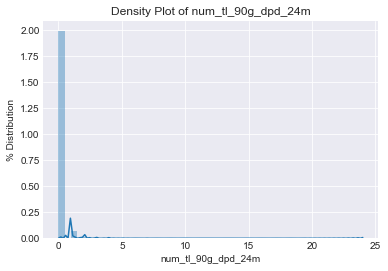

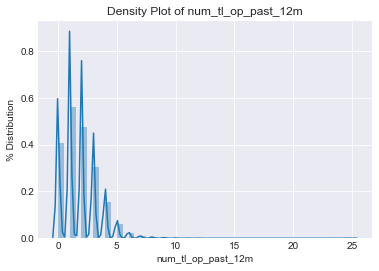

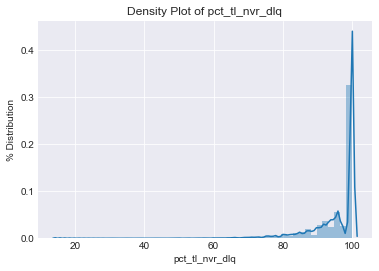

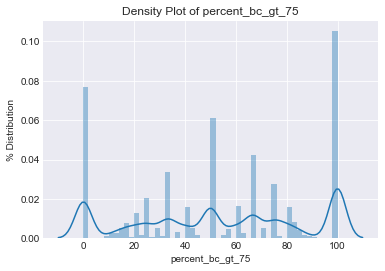

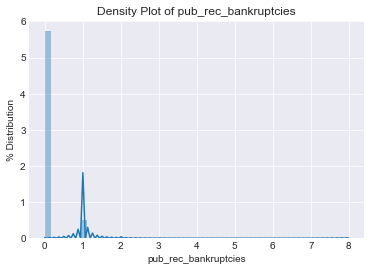

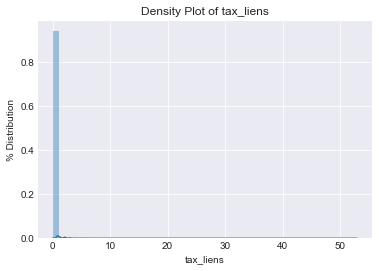

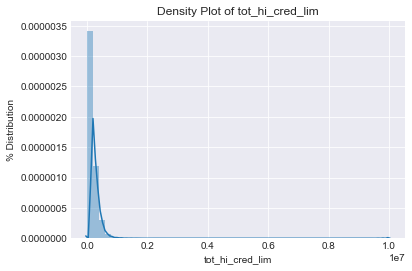

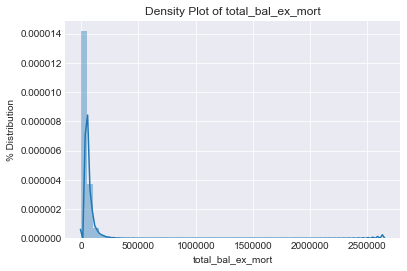

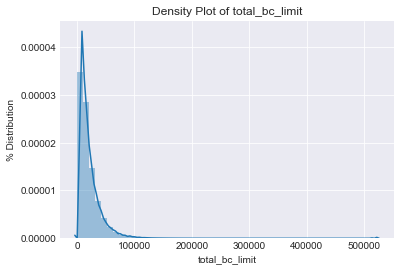

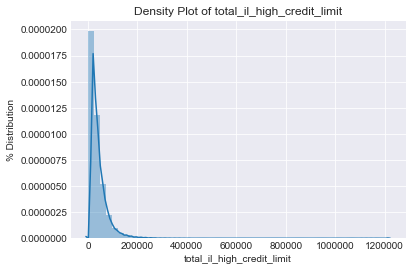

In [82]:
#Visulaiing distribution of continuous variables 
con_plot(lc_num,con_list)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a629a90>,
      dtype=object)

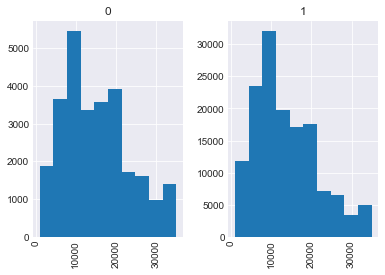

In [27]:
lc_num['loan_amnt'].hist(by = lc_cat["loan_status"])

In [83]:
#Imputation of missing varaibles. For numerical mean is imputed and for categorical most_frequent item is imputed
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Categorical Columns  are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)



In [84]:
#Applying the imputer function
X = pd.DataFrame(lclub)
lclub_clean = DataFrameImputer().fit_transform(X)
lclub_clean.head()

,loan_amnt,funded_amnt_inv,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,20800.0,20800.0,36 months,706.16,10+ years,RENT,81500.0,Verified,Dec-13,1,...,0.0,3.0,90.2,50.0,0.0,0.0,43100.0,23473.0,15000.0,0.0
2,12000.0,12000.0,36 months,392.81,4 years,RENT,60000.0,Not Verified,Dec-13,1,...,0.0,4.0,100.0,0.0,0.0,0.0,29700.0,7137.0,18100.0,0.0
3,12000.0,12000.0,36 months,407.40,10+ years,RENT,40000.0,Source Verified,Dec-13,1,...,0.0,2.0,81.2,33.3,0.0,0.0,18130.0,13605.0,7000.0,10030.0
4,24000.0,24000.0,36 months,814.80,10+ years,MORTGAGE,100000.0,Verified,Dec-13,1,...,0.0,2.0,100.0,75.0,0.0,0.0,229072.0,61397.0,21500.0,58847.0
6,28000.0,28000.0,36 months,872.52,5 years,MORTGAGE,325000.0,Source Verified,Dec-13,1,...,0.0,5.0,100.0,16.7,0.0,0.0,850886.0,199739.0,42200.0,196686.0


In [85]:
#checking missing values now
lclub_clean.isnull().sum()/len(lclub_clean)*100

loan_amnt                     0.0
funded_amnt_inv               0.0
term                          0.0
installment                   0.0
emp_length                    0.0
home_ownership                0.0
annual_inc                    0.0
verification_status           0.0
issue_d                       0.0
loan_status                   0.0
purpose                       0.0
addr_state                    0.0
dti                           0.0
delinq_2yrs                   0.0
earliest_cr_line              0.0
fico_range_low                0.0
fico_range_high               0.0
inq_last_6mths                0.0
open_acc                      0.0
pub_rec                       0.0
revol_bal                     0.0
revol_util                    0.0
total_acc                     0.0
initial_list_status           0.0
collections_12_mths_ex_med    0.0
policy_code                   0.0
acc_now_delinq                0.0
tot_coll_amt                  0.0
tot_cur_bal                   0.0
total_rev_hi_l

## Coding of Categorical columns:

Now categorical columns needs to be coded with factors for carrying out various ML techniques. For this Labelencoder() function needs to be applied. But this function will encode every variables(continuous too).Hence we need to seperate out continuous & categorical variables and peform encoding on categorical variables. 

In [86]:
#seperate cat and continuous variables
lclub_num = lclub_clean.select_dtypes(exclude = ['object'])
lclub_cat = lclub_clean.select_dtypes(include = ['object'])

In [87]:
#encoding for categorical variables
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
lclub_cat = lclub_cat.apply(LabelEncoder().fit_transform)

In [88]:
lclub_cat.shape

(171485, 10)

In [89]:
lclub_num.shape

(171485, 53)

In [90]:
#joining numerical and encoded categorical variables
lc = lclub_num.join(lclub_cat)
lc.head()

,loan_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,...,term,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,addr_state,earliest_cr_line,initial_list_status
0,20800.0,20800.0,706.16,81500.0,16.73,0.0,685.0,689.0,2.0,29.0,...,0,1,4,2,5,1,2,32,345,0
2,12000.0,12000.0,392.81,60000.0,4.62,0.0,720.0,724.0,1.0,15.0,...,0,4,4,0,5,1,2,26,106,0
3,12000.0,12000.0,407.40,40000.0,16.94,0.0,660.0,664.0,0.0,7.0,...,0,1,4,1,5,1,2,30,557,1
4,24000.0,24000.0,814.80,100000.0,22.18,0.0,660.0,664.0,0.0,14.0,...,0,1,0,2,5,1,1,21,237,1
6,28000.0,28000.0,872.52,325000.0,18.55,0.0,745.0,749.0,1.0,15.0,...,0,5,0,1,5,1,2,4,499,1


In [91]:
lc.shape

(171485, 63)

In [102]:
# defining target and predictor variables 
Y = lc["loan_status"]
X = lc.drop(["loan_status" ], axis = 1)

### Random Forest Classifier for feature selection 

There is always a possibility of overfitting due to this high dimensional data(Curse of dimensionality). Its recommended to carry out feature selection using various techniques. One of them is using Ensemble classification Random Forest Classifier 

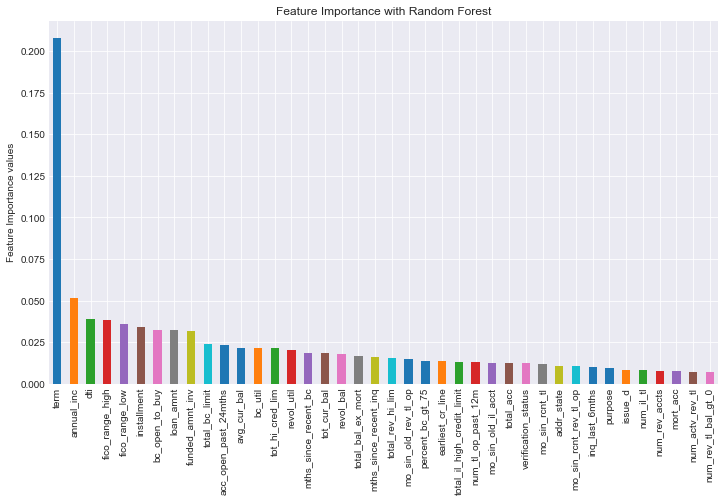

In [93]:
#Random forest classifier
from sklearn.ensemble import RandomForestClassifier


rf_clf = RandomForestClassifier(max_depth=15,n_estimators=250, min_samples_leaf=50,
                                  min_samples_split=100, random_state=10)

# Train the model
rf_clf.fit(X,Y)

# Plot the top 40 important features
imp_feat_rf = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
imp_feat_rf[:40].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance values')
plt.subplots_adjust(bottom=0.25)
plt.savefig('FeatImportance.png')
plt.show()

In [94]:
# Feature ranking from Random forest classifier
print(imp_feat_rf)

term                          0.208084
annual_inc                    0.051526
dti                           0.038845
fico_range_high               0.038134
fico_range_low                0.035814
installment                   0.034264
bc_open_to_buy                0.032478
loan_amnt                     0.032188
funded_amnt_inv               0.031649
total_bc_limit                0.023993
acc_open_past_24mths          0.023143
avg_cur_bal                   0.021674
bc_util                       0.021365
tot_hi_cred_lim               0.021181
revol_util                    0.020260
mths_since_recent_bc          0.018665
tot_cur_bal                   0.018661
revol_bal                     0.017750
total_bal_ex_mort             0.016376
mths_since_recent_inq         0.016209
total_rev_hi_lim              0.015500
mo_sin_old_rev_tl_op          0.014661
percent_bc_gt_75              0.013631
earliest_cr_line              0.013480
total_il_high_credit_limit    0.013242
num_tl_op_past_12m       

In [118]:
#selecting top 15 features 
X1=  X [['annual_inc','dti','fico_range_high','fico_range_low','installment','bc_open_to_buy',
                  'loan_amnt','funded_amnt_inv','total_bc_limit','acc_open_past_24mths','avg_cur_bal',
                  'bc_util','tot_hi_cred_lim','revol_util','mths_since_recent_bc','tot_cur_bal',
                  'revol_bal','total_bal_ex_mort']]

In [119]:
# train and test with 25% split
x_train, x_test, y_train, y_test = train_test_split(X1, Y,
                                                  test_size = .25,random_state=12)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
lr = LogisticRegression()

from sklearn import model_selection

#setting pipeline for standardizing and fitting classification algorithm
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),('model', lr) ])

#Fitting the model
lr_model        = pipeline.fit(x_train, y_train)
score = cross_val_score(lr_model, x_train, y_train, cv=5, verbose=3)
score.mean()
y_pred = lr_model.predict(x_test)

#predictions
pred_train         = lr_model.predict(x_train)
conf_mat_train = confusion_matrix(y_train, pred_train)
pred_test      = lr_model.predict(x_test)
conf_mat_test  = confusion_matrix(y_test, y_pred)
#Confusion matrix and Scores
print(" \nConfusion matrix for train:\n ", conf_mat_train)
print(classification_report(y_train, pred_train, target_names=['0', '1']))

print(" \nConfusion matrix for test:\n ", conf_mat_test)
print(classification_report(y_test, y_pred, target_names=['0', '1']))

[CV]  ................................................................
[CV] ....................................... , score=0.839093 -   0.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ....................................... , score=0.838938 -   1.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] ....................................... , score=0.839327 -   1.1s
[CV]  ................................................................
[CV] ....................................... , score=0.839515 -   1.0s
[CV]  ................................................................
[CV] ....................................... , score=0.839826 -   0.9s
Precision: 83.93%
Recall: 99.75%


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.8s finished


 
Confusion matrix for train:
  [[   230  20408]
 [   252 107723]]
             precision    recall  f1-score   support

          0       0.48      0.01      0.02     20638
          1       0.84      1.00      0.91    107975

avg / total       0.78      0.84      0.77    128613

 
Confusion matrix for test:
  [[   60  6866]
 [   89 35857]]
             precision    recall  f1-score   support

          0       0.40      0.01      0.02      6926
          1       0.84      1.00      0.91     35946

avg / total       0.77      0.84      0.77     42872



In [134]:
#Naive bayes 

from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
cv = model_selection.KFold(5)
nb = GaussianNB() 

#setting pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),('model', nb) ])

# Gridsearch CV
from sklearn.model_selection import GridSearchCV
optimized_nb = GridSearchCV(estimator=pipeline,cv=cv,param_grid=dict(), scoring = 'completeness_score'
                            , verbose = 1, n_jobs = -1)

#Fitting the model with Grid Search
nb_model        = optimized_nb.fit(x_train, y_train)
pred_train         = nb_model.predict(x_train)
conf_mat_train = confusion_matrix(y_train, pred_train)
pred_test      = nb_model.predict(x_test)
conf_mat_test  = confusion_matrix(y_test, pred_test)
#Confusion matrix and Scores
print(" \nConfusion matrix for train:\n ", conf_mat_train)
print(classification_report(y_train, pred_train, target_names=['0', '1']))

print(" \nConfusion matrix for test:\n ", conf_mat_test)
print(classification_report(y_test, pred_test, target_names=['0', '1']))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


 
Confusion matrix for train:
  [[11173  9465]
 [38976 68999]]
             precision    recall  f1-score   support

          0       0.22      0.54      0.32     20638
          1       0.88      0.64      0.74    107975

avg / total       0.77      0.62      0.67    128613

 
Confusion matrix for test:
  [[ 3682  3244]
 [13126 22820]]
             precision    recall  f1-score   support

          0       0.22      0.53      0.31      6926
          1       0.88      0.63      0.74     35946

avg / total       0.77      0.62      0.67     42872



In [139]:
#K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# K-fold cross validation 
from sklearn import model_selection

#setting pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),('model', knn) ])

# Gridsearch CV
from sklearn.model_selection import GridSearchCV
optimized_knn = GridSearchCV(estimator=pipeline,cv=5,param_grid=dict(), scoring = 'completeness_score'
                            , verbose = 1, n_jobs = -1)

#Fitting the model with Grid Search
knn_model        = optimized_knn.fit(x_train, y_train)
pred_train         = knn_model.predict(x_train)
conf_mat_train = confusion_matrix(y_train, pred_train)
pred_test      = knn_model.predict(x_test)
conf_mat_test  = confusion_matrix(y_test, pred_test)
#Confusion matrix and Scores
print(" \nConfusion matrix for train:\n ", conf_mat_train)
print(classification_report(y_train, pred_train, target_names=['0', '1']))

print(" \nConfusion matrix for test:\n ", conf_mat_test)

print(classification_report(y_test, pred_test, target_names=['0', '1']))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.2min finished


 
Confusion matrix for train:
  [[  3962  16676]
 [  1990 105985]]
             precision    recall  f1-score   support

          0       0.67      0.19      0.30     20638
          1       0.86      0.98      0.92    107975

avg / total       0.83      0.85      0.82    128613

 
Confusion matrix for test:
  [[  533  6393]
 [ 1366 34580]]
             precision    recall  f1-score   support

          0       0.28      0.08      0.12      6926
          1       0.84      0.96      0.90     35946

avg / total       0.75      0.82      0.77     42872



In [125]:
#decision tree

dt = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=10, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')

# K-fold cross validation 
from sklearn import model_selection
cv = model_selection.KFold(5)

#setting pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),('model', dt) ])

# Gridsearch CV
from sklearn.model_selection import GridSearchCV
optimized_dt = GridSearchCV(estimator=pipeline,cv=cv,param_grid=dict(), scoring = 'completeness_score'
                            , verbose = 1, n_jobs = -1)

#Fitting the model with Grid Search
dt_model        = optimized_dt.fit(x_train, y_train)
pred_train         = dt_model.predict(x_train)
conf_mat_train = confusion_matrix(y_train, pred_train)
pred_test      = dt_model.predict(x_test)
conf_mat_test  = confusion_matrix(y_test, pred_test)
#Confusion matrix and Scores
print(" \nConfusion matrix for train:\n ", conf_mat_train)
print(classification_report(y_train, pred_train, target_names=['0', '1']))

print(" \nConfusion matrix for test:\n ", conf_mat_test)

print(classification_report(y_test, pred_test, target_names=['0', '1']))

/Users/anveshd9/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


 
Confusion matrix for train:
  [[61325 46650]
 [40130 67845]]
             precision    recall  f1-score   support

          0       0.60      0.57      0.59    107975
          1       0.59      0.63      0.61    107975

avg / total       0.60      0.60      0.60    215950

 
Confusion matrix for test:
  [[ 3504  3422]
 [13256 22690]]
             precision    recall  f1-score   support

          0       0.21      0.51      0.30      6926
          1       0.87      0.63      0.73     35946

avg / total       0.76      0.61      0.66     42872



### By looking at Precision,Recall scores for all the classifiers,we can observe that KNN is a better model to predict potential defaulters when compared to other classifiers. 